In [1]:
from PIL import Image, ImageDraw, ImageFont
from IPython.display import Image as Img

import numpy as np

from scipy import ndimage as ndi
from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.image as mpimg

import skimage
from skimage import filters, morphology, measure, data, img_as_float
from skimage.measure import label, regionprops
from skimage.morphology import watershed, closing, square, reconstruction
from skimage.feature import canny, corner_harris, corner_subpix, corner_peaks
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.color import label2rgb
from skimage.transform import warp, AffineTransform
from skimage.draw import ellipse

## Чтение изображения

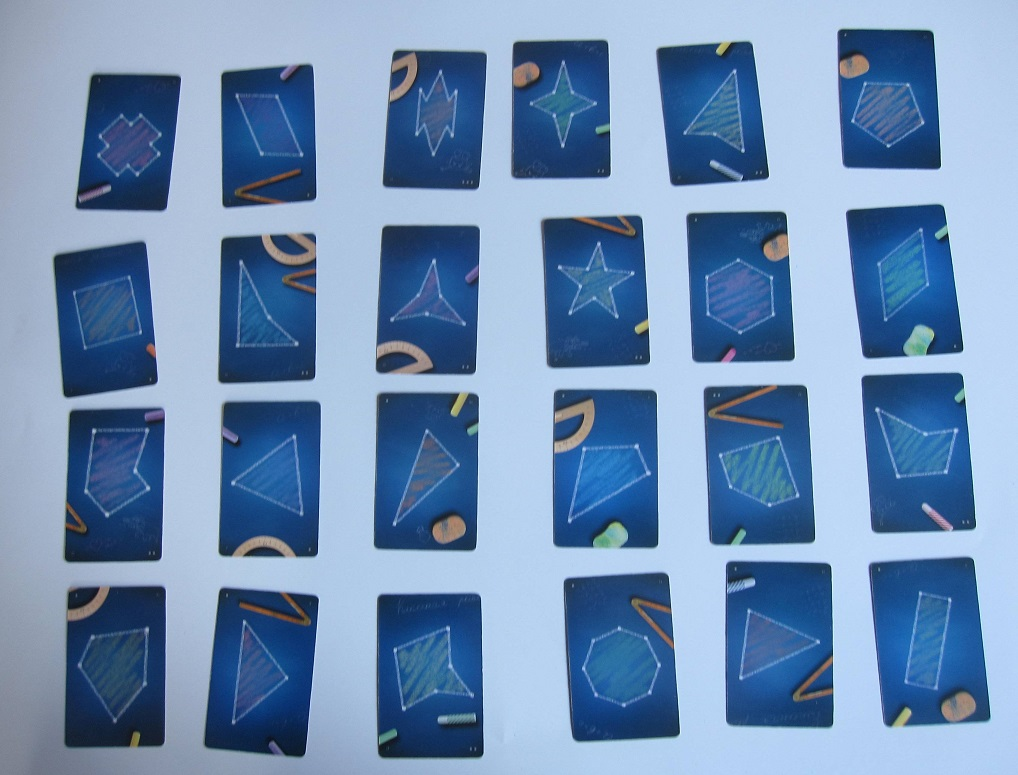

In [2]:
pict_num = 6
filename = 'IMG_' + str(pict_num) + '.jpg'
Img(filename=filename, width=400, height=400)

In [3]:
def load_image(infilename):
    img = Image.open(infilename)
    img.load()
    data = np.asarray(img)
    img.close()
    return data.copy()

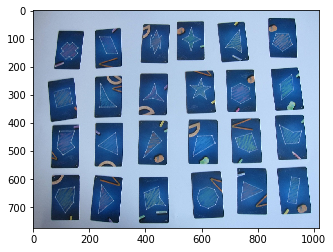

In [4]:
image = load_image('IMG_' + str(pict_num) + '.jpg')
plt.imshow(image)
#plt.savefig('img4.jpg')

(0, 255)

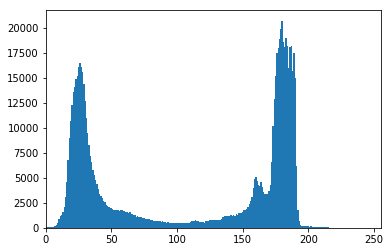

In [5]:
red_channel = image[:, :, 0]
red_hist, red_bin_edges = np.histogram(red_channel, bins=range(256))
plt.bar(red_bin_edges[:-1], red_hist, width = 1)
plt.xlim(min(red_bin_edges), max(red_bin_edges))
#plt.savefig('histogram2.pdf')

## Система RGB

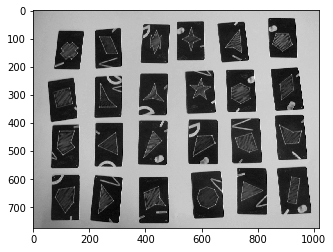

In [6]:
red_channel = image[:, :, 0]
plt.imshow(red_channel, cmap='gray')
#plt.savefig('red_channel_1.jpg')

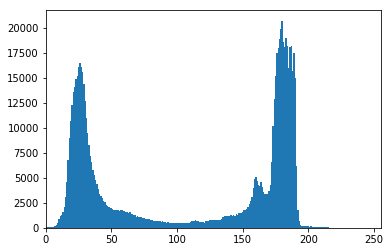

In [7]:
red_hist, red_bin_edges = np.histogram(red_channel, bins=range(256))
plt.bar(red_bin_edges[:-1], red_hist, width = 1)
plt.xlim(min(red_bin_edges), max(red_bin_edges))
plt.show()

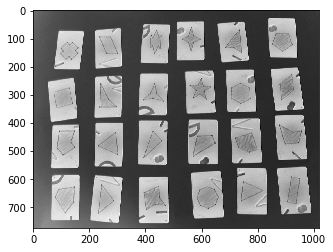

In [8]:
green_channel = image[:, :, 1] * 255
plt.imshow(green_channel, cmap='gray')

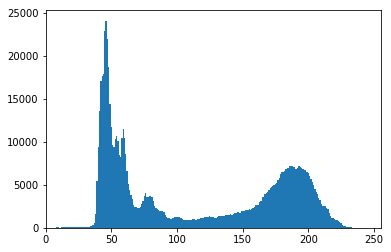

In [9]:
green_hist, green_bin_edges = np.histogram(green_channel, bins=range(256))
plt.bar(green_bin_edges[:-1], green_hist, width = 1)
plt.xlim(min(green_bin_edges), max(green_bin_edges))
plt.show()

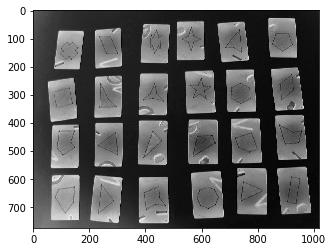

In [10]:
blue_channel = image[:, :, 2] * 255
plt.imshow(blue_channel, cmap='gray')

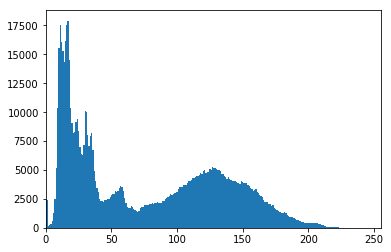

In [11]:
blue_hist, blue_bin_edges = np.histogram(blue_channel, bins=range(256))
plt.bar(blue_bin_edges[:-1], blue_hist, width = 1)
plt.xlim(min(blue_bin_edges), max(blue_bin_edges))
plt.show()

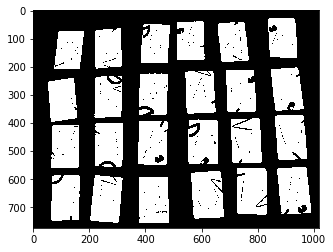

In [12]:
thresh = threshold_otsu(red_channel)
mask = red_channel >= thresh
rgb_binary_im = np.zeros_like(red_channel)
rgb_binary_im[~mask] = 255
plt.imshow(rgb_binary_im, cmap='gray')
#plt.savefig('binarization.jpg')

In [13]:
ratio = np.argmax(red_channel) / red_hist[thresh]
print(ratio)
if ratio < 500:
    use_hsv = True
else:
    use_hsv = False

553.967320261


## Переход в систему HSV

In [14]:
def remove_small_components(image, min_area=1000):
    label_objects, nb_labels = ndi.label(image)
    sizes = np.bincount(label_objects.ravel())
    mask_sizes = sizes > min_area
    mask_sizes[0] = 0
    return mask_sizes[label_objects]

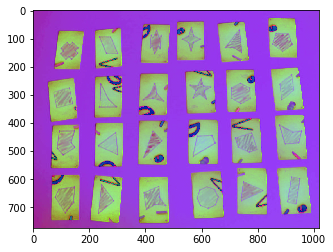

In [15]:
hsv_image = skimage.color.rgb2hsv(image)
plt.imshow(hsv_image, cmap='gray')

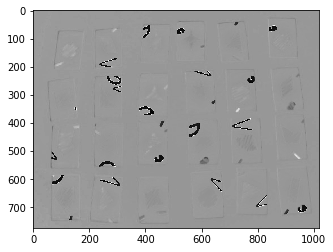

In [16]:
hue_channel = hsv_image[:, :, 0] * 255
plt.imshow(hue_channel, cmap='gray')
#plt.savefig('hue_channel.jpg')

(0, 255)

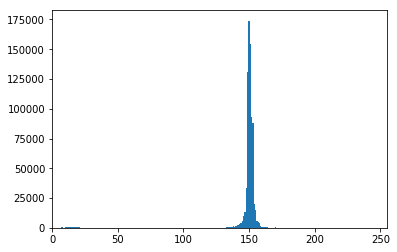

In [17]:
hue_hist, hue_bin_edges = np.histogram(hue_channel, bins=range(256))
plt.bar(hue_bin_edges[:-1], hue_hist, width = 1)
plt.xlim(min(hue_bin_edges), max(hue_bin_edges))
#plt.savefig('histogram.pdf')

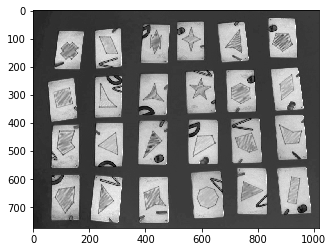

In [18]:
sat_channel = hsv_image[:, :, 1] * 255
plt.imshow(sat_channel, cmap='gray')

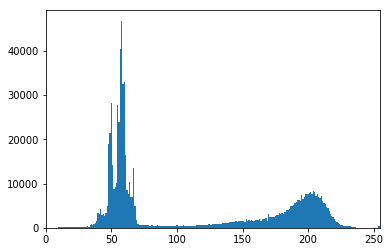

In [19]:
sat_hist, sat_bin_edges = np.histogram(sat_channel, bins=range(256))
plt.bar(sat_bin_edges[:-1], sat_hist, width = 1)
plt.xlim(min(sat_bin_edges), max(sat_bin_edges))
plt.show()

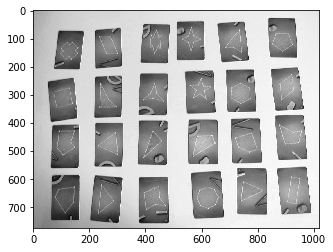

In [20]:
val_channel = hsv_image[:, :, 2] * 255
plt.imshow(val_channel, cmap='gray')

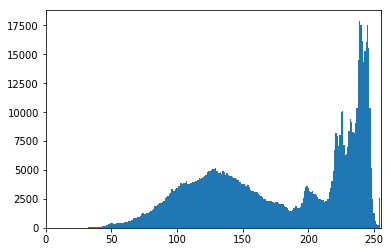

In [21]:
val_hist, val_bin_edges = np.histogram(val_channel, bins=range(256))
plt.bar(val_bin_edges[:-1], val_hist, width = 1)
plt.xlim(min(val_bin_edges), max(val_bin_edges))
plt.show()

## Определяем границы гауссианы

In [22]:
gauss_range = 20

In [23]:
mode = np.argmax(hue_hist)
mode

150

In [24]:
hue_hist[mode - gauss_range:mode + gauss_range]

array([   132,    119,    195,    281,    328,    319,    651,    349,
         1149,   1016,   1224,   1956,   2243,   3070,   4127,   5605,
        10068,  13406,  33217, 130996, 173933, 154194,  93477,  87755,
        19755,  14979,   5496,   4769,   3735,   1197,    829,    806,
          481,    419,    373,    196,    196,    148,    105,     37])

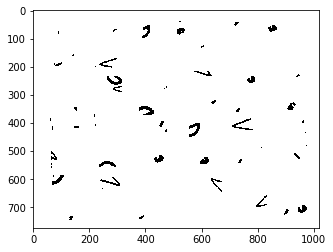

In [25]:
mask = (hue_channel >= mode - gauss_range) & (hue_channel <= mode + gauss_range)
hsv_binary_im = np.zeros_like(hue_channel)
hsv_binary_im[mask] = 255
plt.imshow(hsv_binary_im, cmap='gray')
#plt.savefig('binarization_5.jpg')

## Очистка от шумов

In [26]:
if use_hsv:
    binary_im = hsv_binary_im
else:
    binary_im = rgb_binary_im

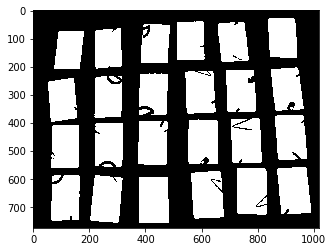

In [27]:
binary_im = ndi.binary_fill_holes(binary_im)
plt.imshow(binary_im, cmap='gray')

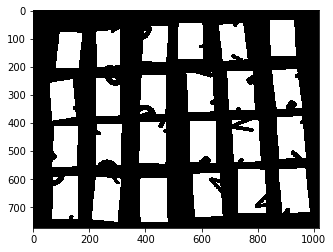

In [28]:
binary_im = morphology.binary_erosion(binary_im, selem=morphology.disk(5))
plt.imshow(binary_im, cmap='gray')

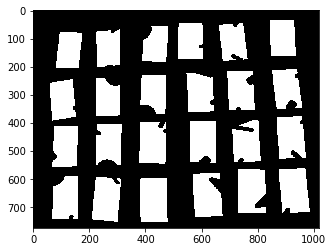

In [29]:
binary_im = remove_small_components(binary_im, min_area=1000)
plt.imshow(binary_im, cmap='gray')

In [30]:
label_objects, nb_labels = ndi.label(binary_im)
print(nb_labels)

24


## Надпись на изображении

In [31]:
def draw_txt(txt):
    image = Image.new("RGB", (600,150), (255,255,255))
    draw = ImageDraw.Draw(image)
    fontsize=80
    font = ImageFont.truetype("helveticaneue-light.ttf", fontsize)

    draw.text((10, 0), txt, (255,0,0), font)
    img_resized = image.resize((188,45), Image.ANTIALIAS)
    img_resized = np.asarray(img_resized)[:30, :70].copy()
    return img_resized

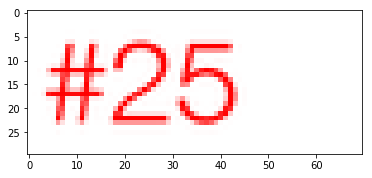

In [32]:
drawn_text = draw_txt('#25')
plt.imshow(drawn_text[:, :])

In [33]:
drawn_text.shape

(30, 70, 3)

## Выделение многоугольников

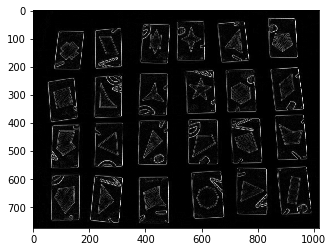

In [34]:
borders = skimage.filters.sobel(sat_channel)
plt.imshow(borders, cmap='gray')
#plt.savefig('borders1.jpg')

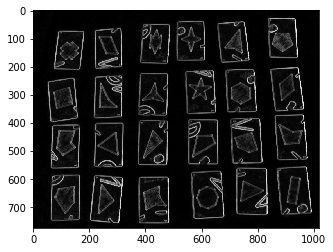

In [35]:
borders = morphology.dilation(borders, selem=morphology.disk(1))
plt.imshow(borders, cmap='gray')
#plt.savefig('borders2.jpg')

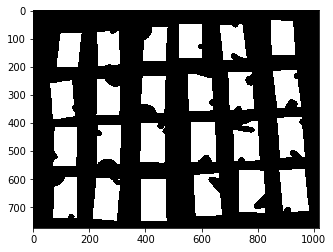

In [36]:
erosion_mask = morphology.binary_erosion(binary_im, selem=morphology.disk(3))
plt.imshow(erosion_mask, cmap='gray')

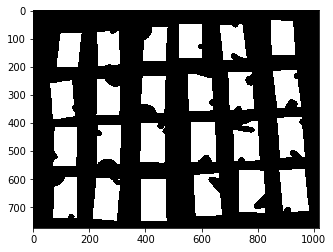

In [37]:
mask = remove_small_components(erosion_mask, min_area=1000)
plt.imshow(erosion_mask, cmap='gray')
#plt.savefig('borders3.jpg')

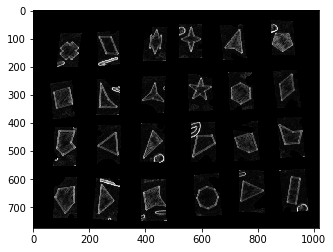

In [38]:
borders[~erosion_mask] = 0
plt.imshow(borders, cmap='gray')
#plt.savefig('borders4.jpg')

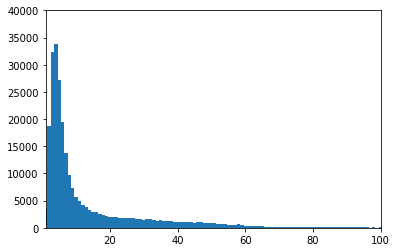

In [39]:
borders_hist, borders_bin_edges = np.histogram(borders, bins=range(256))
plt.bar(borders_bin_edges[:-1], borders_hist, width = 1)
plt.xlim(min(borders_bin_edges) + 1, 100)
plt.ylim(0, 40000)
plt.show()

In [40]:
np.argmax(borders_hist[1:]) + 1

4

In [41]:
thresh = threshold_otsu(borders)
thresh

22.039564931608382

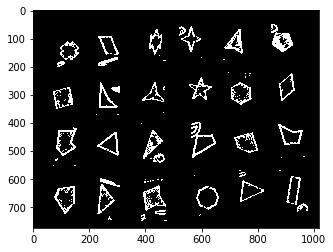

In [42]:
mask = borders >= thresh
polygon_borders = np.zeros_like(borders)
polygon_borders[mask] = 255
plt.imshow(polygon_borders, cmap='gray')
#plt.savefig('borders5.jpg')

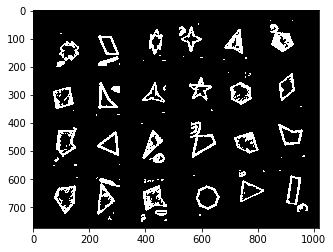

In [43]:
polygon_borders = morphology.dilation(polygon_borders, selem=morphology.disk(1))
plt.imshow(polygon_borders, cmap='gray')

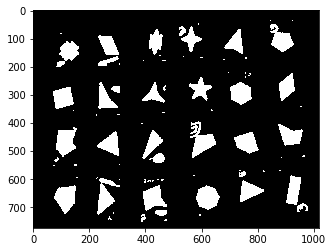

In [44]:
polygon_borders = ndi.binary_fill_holes(polygon_borders)
plt.imshow(polygon_borders, cmap='gray')

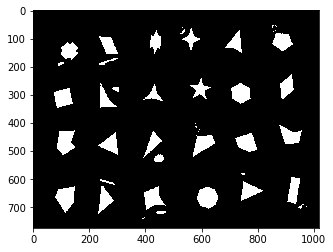

In [45]:
polygon_borders = morphology.binary_erosion(polygon_borders, selem=morphology.disk(4))
plt.imshow(polygon_borders, cmap='gray')

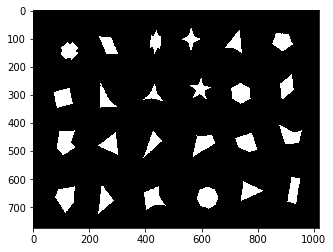

In [46]:
polygon_borders = remove_small_components(polygon_borders, min_area=1000)
plt.imshow(polygon_borders, cmap='gray')

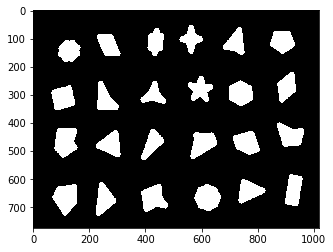

In [47]:
polygon_borders = morphology.binary_dilation(polygon_borders, selem=morphology.disk(9))
plt.imshow(polygon_borders, cmap='gray')
#plt.savefig('borders6.jpg')

In [48]:
binary_im = polygon_borders

## Сегментация

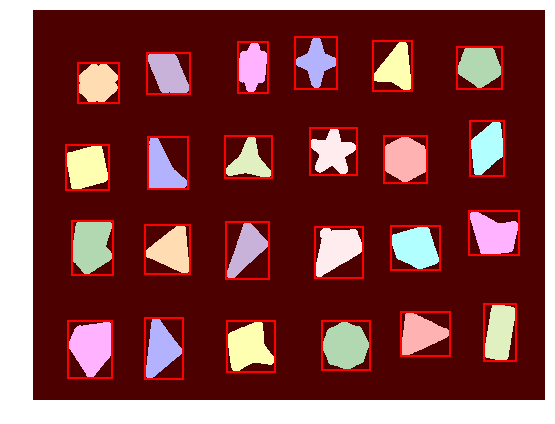

In [49]:
label_image = label(binary_im)
image_label_overlay = label2rgb(label_image, image=binary_im)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()
#http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html

In [50]:
label_image = label(binary_im)
image_label_overlay = label2rgb(label_image, image=binary_im)

for i, region in enumerate(regionprops(label_image)):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        num_im = draw_txt('#' + str(i + 1))
        center_r = (maxr + minr) // 2
        center_c = (maxc + minc) // 2
        image[center_r - 15:center_r + 15, center_c - 35:center_c + 35] = num_im

In [51]:
result = Image.fromarray(image)
result.save(filename[:-4] + '_LABELED' + '.jpg')

## Определение геометрической фигуры

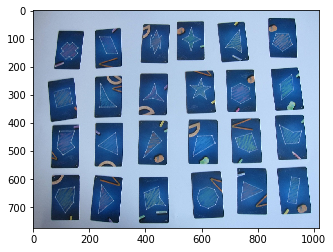

In [52]:
image = load_image('IMG_' + str(pict_num) + '.jpg')
plt.imshow(image)

In [53]:
def find_corners(image, min_distance=4):
    coords = corner_peaks(corner_harris(image, k=0.05, eps=1e-6, sigma=1), min_distance=min_distance)
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_title(str(coords.shape[0]) + ' corners')
    ax.plot(coords[:, 1], coords[:, 0], '.r', markersize=15)
#http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_corner.html

/home/michael/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


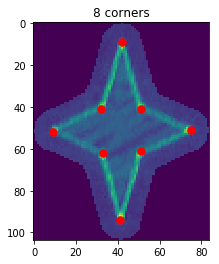

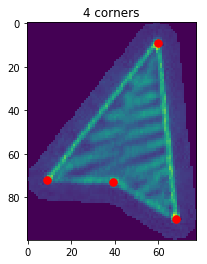

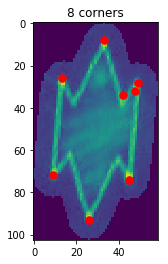

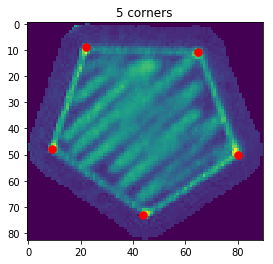

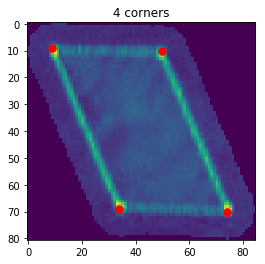

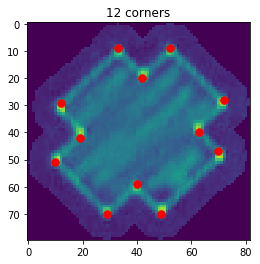

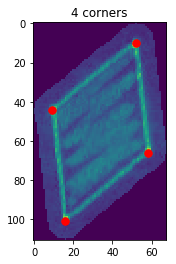

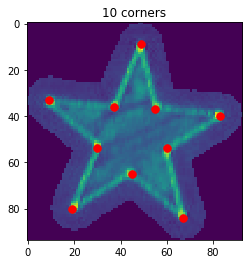

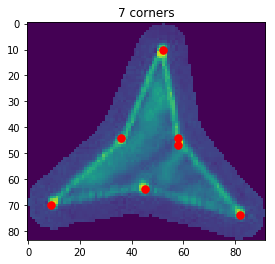

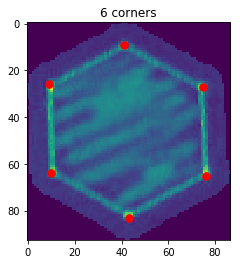

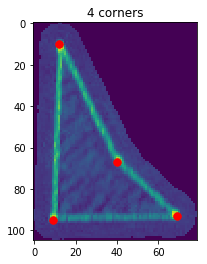

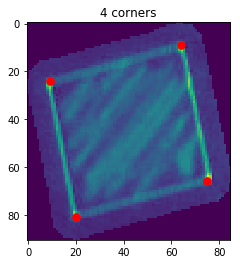

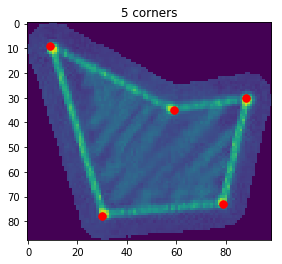

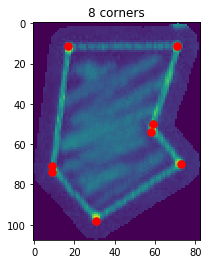

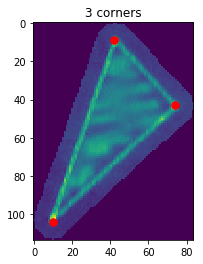

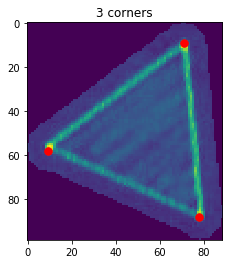

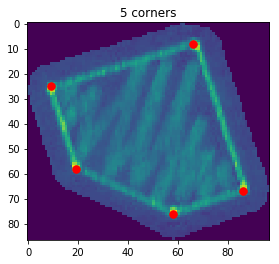

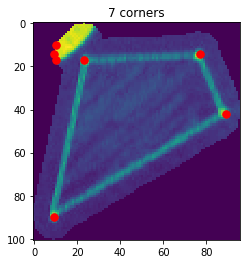

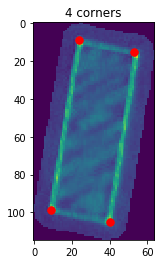

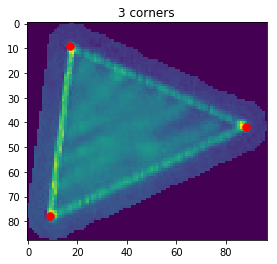

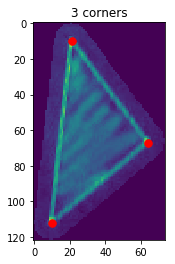

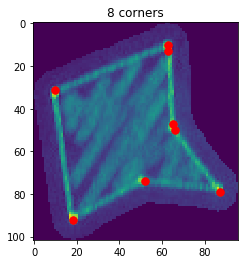

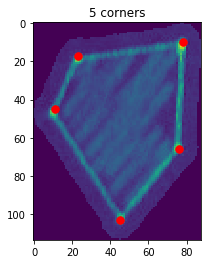

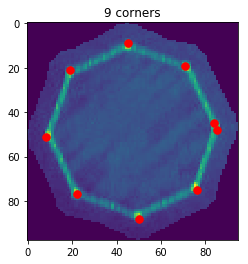

In [54]:
label_image = label(binary_im)
image_label_overlay = label2rgb(label_image, image=binary_im)

for i, region in enumerate(regionprops(label_image)):
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                               fill=False, edgecolor='red', linewidth=2)
    in_image = image[:, :, 0]
    fragm = in_image[minr:maxr, minc:maxc].copy()
    mask = (label_image == i + 1)[minr:maxr, minc:maxc]
    fragm[~mask] = 0
    find_corners(fragm, min_distance=2)
    #plt.savefig('polygons' + str(i) + '.jpg')
    #http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html

/home/michael/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


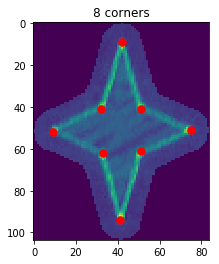

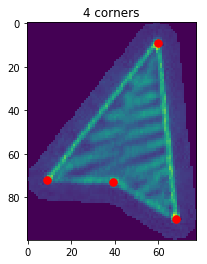

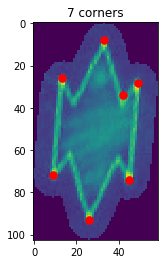

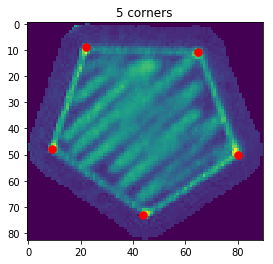

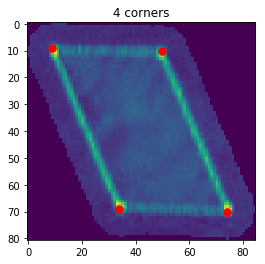

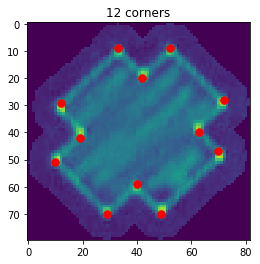

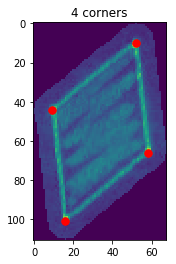

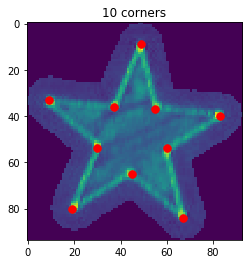

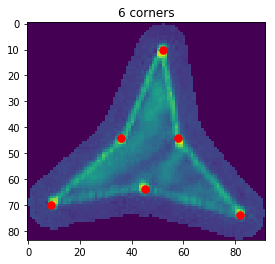

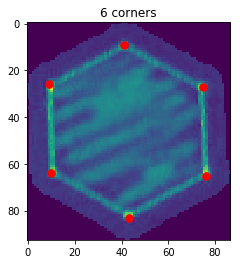

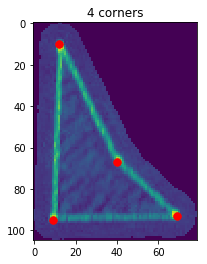

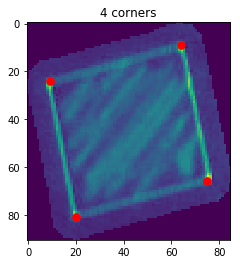

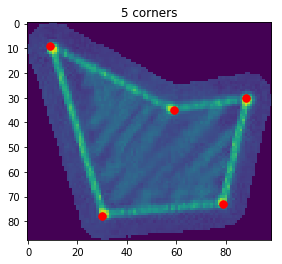

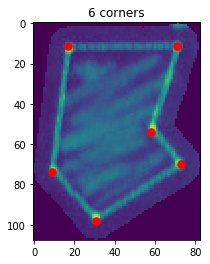

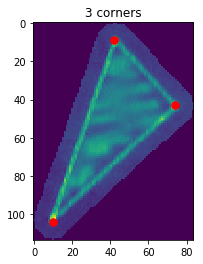

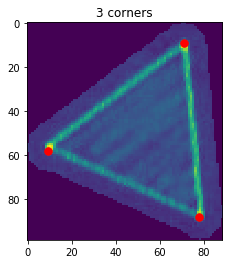

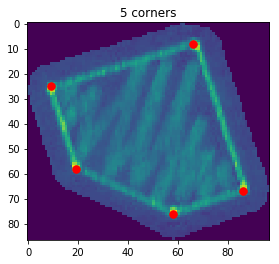

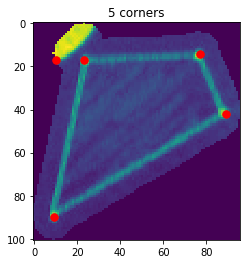

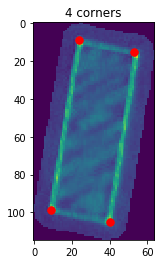

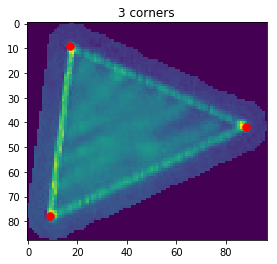

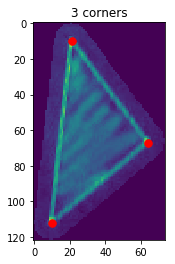

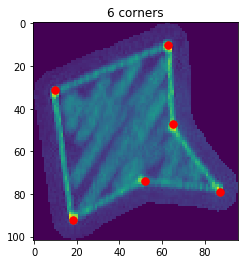

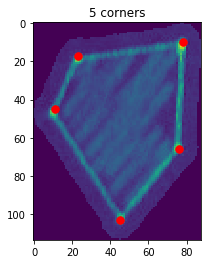

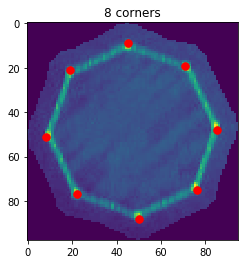

In [55]:
label_image = label(binary_im)
image_label_overlay = label2rgb(label_image, image=binary_im)

for i, region in enumerate(regionprops(label_image)):
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                               fill=False, edgecolor='red', linewidth=2)
    in_image = image[:, :, 0]
    fragm = in_image[minr:maxr, minc:maxc].copy()
    mask = (label_image == i + 1)[minr:maxr, minc:maxc]
    fragm[~mask] = 0
    find_corners(fragm)
    #plt.savefig('polygons_' + str(i) + '.jpg')
    #http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html

In [56]:
label_image = label(binary_im)
image_label_overlay = label2rgb(label_image, image=binary_im)

for i, region in enumerate(regionprops(label_image)):
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                               fill=False, edgecolor='red', linewidth=2)
    in_image = image[:, :, 0]
    fragm = in_image[minr:maxr, minc:maxc].copy()
    mask = (label_image == i + 1)[minr:maxr, minc:maxc]
    fragm[~mask] = 0
    coords = corner_peaks(corner_harris(fragm, k=0.05, eps=1e-6, sigma=1), min_distance=2)
    if coords.shape[0] <= 17:
        label_to_print = "P"
        coords = corner_peaks(corner_harris(fragm, k=0.05, eps=1e-6, sigma=1), min_distance=5)
        label_to_print += str(coords.shape[0])
        if region.convex_area - region.area < 300:
            label_to_print += "C"
        drawn_text = draw_txt(label_to_print)
        center_r = (maxr + minr) // 2
        center_c = (maxc + minc) // 2s
        image[center_r - 15:center_r + 15, center_c - 35:center_c + 35] = drawn_text
#http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html

In [57]:
result = Image.fromarray(image)
result.save(filename[:-4] + '_POLYGONS' + '.jpg')